In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [140]:
DIRECTORY = r"C:\Users\ashu1\OneDrive\Desktop\My Projects Data\Face_Mask_Detection"
CATEGORIES = ['with_mask', 'without_mask']

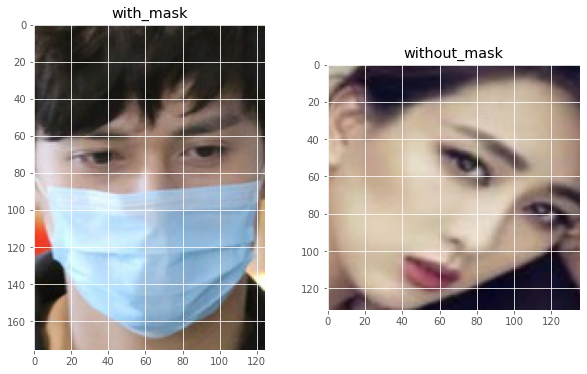

In [141]:
mask_path = os.path.join(DIRECTORY, CATEGORIES[0])
without_mask_path = os.path.join(DIRECTORY, CATEGORIES[1])
                         
rand_with_mask_img = random.choice(os.listdir(mask_path))
rand_without_mask_img = random.choice(os.listdir(without_mask_path))

image_with_mask = os.path.join(mask_path, rand_with_mask_img)
image_without_mask = os.path.join(without_mask_path, rand_without_mask_img)

plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_with_mask))
plt.title("with_mask")

plt.subplot(1, 2, 2)
plt.imshow(Image.open(image_without_mask))
plt.title("without_mask")
plt.show();

In [142]:
data = []
labels = []

In [143]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img = load_img(img_path, target_size = (224, 224))
        image = img_to_array(img)
        
        data.append(image)
        labels.append(category)

In [144]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [145]:
data = np.array(data, dtype = 'float32')
labels = np.array(labels)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2 , stratify = labels, random_state = 42)

In [147]:
img_aug = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode="nearest")

In [148]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation="relu", input_shape = (128, 128, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(32, (3, 3), activation="relu"))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(32, (3, 3), activation="relu"))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Flatten())

# model.add(Dense(activation="relu", units = 128))
# model.add(Dropout(0.3))
# model.add(Dense(activation="sigmoid", units = 2))

# model.compile(optimizer = "Adam", loss= "binary_crossentropy", metrics = ["accuracy"])

In [149]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [150]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [151]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [152]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [153]:
H = model.fit(img_aug.flow(X_train, y_train, batch_size=BS),
              steps_per_epoch=len(X_train) // BS,
              validation_data=(X_test, y_test),
              validation_steps=len(X_test) // BS,
              epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 66s 690ms/step - loss: 0.6309 - accuracy: 0.6809 - val_loss: 0.4681 - val_accuracy: 0.7810
Epoch 2/20
95/95 [==============================] - 65s 684ms/step - loss: 0.4235 - accuracy: 0.8138 - val_loss: 0.3658 - val_accuracy: 0.8449
Epoch 3/20
95/95 [==============================] - 65s 688ms/step - loss: 0.3825 - accuracy: 0.8431 - val_loss: 0.3373 - val_accuracy: 0.8553
Epoch 4/20
95/95 [==============================] - 70s 742ms/step - loss: 0.3454 - accuracy: 0.8603 - val_loss: 0.3220 - val_accuracy: 0.8618
Epoch 5/20
95/95 [==============================] - 66s 697ms/step - loss: 0.3248 - accuracy: 0.8724 - val_loss: 0.2864 - val_accuracy: 0.8853
Epoch 6/20
95/95 [==============================] - 66s 694ms/step - loss: 0.2973 - accuracy: 0.8833 - val_loss: 0.2722 - val_accuracy: 0.8840
Epoch 7/20
95/95 [==============================] - 66s 691ms/step - loss: 0.2917 - accuracy: 0.8804 - val_loss: 0.2605 - val_accuracy: 0.8996

KeyboardInterrupt: 

In [ ]:
# model.fit(img_aug.flow(X_train, y_train, batch_size = batch_size), epochs = EPOCHS, validation_data = (X_test, y_test), callbacks = [checkpoint])

In [ ]:
y_pred = model.predict(X_test, batch_size = batch_size)

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
#report = classification_report(y_test.argmax(axis = 1), y_pred, target_names = lb.classes_, output_dict = True)
#pd.DataFrame(report).transpose()
accuracy = round(accuracy_score(y_test.argmax(axis = 1), y_pred)*100, 2)
print("Testing Accuracy:", accuracy)

In [ ]:
model.save("mask_detector1.model", save_format="h5")

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Training set', 'Validation set'], loc = 'upper left')
plt.show()

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training set', 'Validation set'], loc = 'upper left')
plt.show()